This notebook demonstrates how you can find adversarial examples for a pre-trained example network on the MNIST dataset.

We suggest having the `Gurobi` solver installed, since its performance is significantly faster. If this is not possible, the `Cbc` solver is another option.

The `Images` package is only necessary for visualizing the MNIST images.

In [1]:
using MIPVerify
using Gurobi
using Images

# Setup

## MNIST dataset

We begin by loading the MNIST dataset. The data is provided as a Julia `struct` for easy access. The training images and test images are provided as a 4-dimensional array of size `(num_samples, height, width, num_channels)`.

In [2]:
mnist = MIPVerify.read_datasets("MNIST")

MNIST:
  `train`: {ImageDataset}
    `images`: 55000 images of size (28, 28, 1), with pixels in [0.0, 1.0].
    `labels`: 55000 corresponding labels, with 10 unique labels in [0, 9].
  `test`: {ImageDataset}
    `images`: 10000 images of size (28, 28, 1), with pixels in [0.0, 1.0].
    `labels`: 10000 corresponding labels, with 10 unique labels in [0, 9].

In [3]:
mnist.train

{ImageDataset}
    `images`: 55000 images of size (28, 28, 1), with pixels in [0.0, 1.0].
    `labels`: 55000 corresponding labels, with 10 unique labels in [0, 9].

In [40]:
size(mnist.train.images)

(55000, 28, 28, 1)

We can use `Images.colorview` to preview these images. 

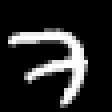

In [39]:
colorview(Gray, mnist.train.images[1, :, :, 1])

In [16]:
mnist.train.labels

55000-element Array{Int64,1}:
 7
 3
 4
 6
 1
 8
 1
 0
 9
 8
 0
 3
 1
 ⋮
 7
 8
 9
 2
 9
 5
 1
 8
 3
 5
 6
 8

## Sample Neural Network

We import a sample pre-trained neural network. 

In [17]:
n1params = MIPVerify.get_example_network_params("MNIST.n1")

convolutional neural net MNIST.n1
  `convlayer_params` [0]:
    (none)
  `fclayer_params` [2]:
    fully connected layer with 784 inputs and 40 output units, and a ReLU activation function.
    fully connected layer with 40 inputs and 20 output units, and a ReLU activation function.
  `softmax_params`:
    softmax layer with 20 inputs and 10 output units.

`MIPVerify.num_correct` allows us to verify that the network has a reasonable accuracy on the test set of 96.95%. (This step is crucial when working with your own neural net parameters; since the training is done outside of Julia, a common mistake is to transfer the parameters incorrectly.)

In [18]:
MIPVerify.num_correct(n1params, "MNIST", 10000)

9695

We feed the first image into the neural net, obtaining the activations of the final softmax layer. 

Note that the image must be specified as a 4-dimensional array with size `(1, height, width, num_channels)`. We provide a helper function `MIPVerify.get_image` that extracts the image from the dataset while preserving all four dimensions.

In [27]:
sample_image = MIPVerify.get_image(mnist.train.images, 1)

1×28×28×1 Array{Float32,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

...

[:, :, 26, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 27, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 28, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [25]:
output_activations = sample_image |> n1params

10-element Array{Float32,1}:
 0.15597 
 0.270125
 1.49147 
 0.145112
 0.281066
 0.385918
 0.228231
 4.10202 
 0.905381
 1.15467 

The category that has the largest activation is category 8, corresponding to a label of 7.

In [26]:
(output_activations |> MIPVerify.get_max_index) - 1

7

This matches the true label.

In [24]:
MIPVerify.get_label(mnist.train.labels, 1)

7

# Finding an Adversarial Example

We now try to find an adversarial example for the first image on `n1params`, setting the target category as index `9` (corresponding to a true label of 8).

Named arguments are described below.
  + `pp`: Specifies the family of perturbations allowed. 
    + Defaults to `MIPVerify.AdditivePerturbationParameters()`.
    + Options are `MIPVerify.AdditivePerturbationParameters()`, corresponding to _additive perturbations_ where each pixel can be modified independently, and `MIPVerify.BlurPerturbationParameters((blur_height, blur_width))`, corresponding to _blurring perturbations_ simulating camera shake.
  + `norm_order`: Specifies the order of the perturbation norm that we are attempting to minimize.
    + Defaults to 1. 
    + Options are `1, 2, Inf`.
  + `tolerance`: Specifies the amount by which the activation in the softmax layer of the target category needs to exceed the activation in the softmax layer of other categories. 
    + Defaults to 0. 
    + Larger values of `tolerance` correspond to the neural net being more certain that the perturbed image has the target label.
  + `rebuild`: Specifies whether to ignore cached models and rebuild the model from scratch. 
    + Defaults to `true`.

(You can safely ignore the messages that look like `WARNING: Not solved to optimality, status: UserLimit`. These are generated as part of the model-building process, and will be muted in a future release).

In [30]:
target_label_index = 9
d = MIPVerify.find_adversarial_example(n1params, sample_image, target_label_index, GurobiSolver, rebuild=false)

Optimize a model with 3385 rows, 3256 columns and 71132 nonzeros
Variable types: 3196 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [2e-05, 7e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e-02, 7e+02]
Presolve removed 2860 rows and 2184 columns
Presolve time: 0.13s
Presolved: 525 rows, 1072 columns, 65472 nonzeros

MIP start did not produce a new incumbent solution
MIP start violates constraint R1024 by 1.000000000

Variable types: 1012 continuous, 60 integer (60 binary)

Root relaxation: objective 0.000000e+00, 252 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    8          -    0.00000      -     -    0s
Another try with MIP start
H    0     0                      55.3332559    0.00000   100%     -    0s
     0     0    0.00000    0    9   55.33326

Dict{Symbol,Any} with 7 entries:
  :PerturbationParameters => MIPVerify.AdditivePerturbationParameters()
  :SolveStatus            => :Optimal
  :Output                 => JuMP.GenericAffExpr{Float64,JuMP.Variable}[-0.0120…
  :Input                  => JuMP.Variable[__anon__ __anon__ __anon__ __anon__ …
  :Model                  => Minimization problem with:…
  :Perturbation           => JuMP.Variable[__anon__ __anon__ __anon__ __anon__ …
  :PerturbedInput         => JuMP.Variable[__anon__ __anon__ __anon__ __anon__ …

In [33]:
using JuMP

perturbed_sample_image = getvalue(d[:PerturbedInput])

1×28×28×1 Array{Float64,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

...

[:, :, 26, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 27, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 28, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

As a sanity check, we feed the perturbed image into the neural net and inspect the activation in the final layer. We verify that the perturbed image does maximize the activation of the target label index, which is 9.

In [35]:
perturbed_sample_image |> n1params

10-element Array{Float64,1}:
 0.257004
 0.416757
 0.692725
 0.38037 
 0.295063
 0.204749
 0.488696
 3.30817 
 3.30817 
 0.551406

We visualize the perturbed image and compare it to the original image. Since we are minimizing the L1-norm, changes are made to only a few pixels, but the magnitude of these changes are large (and noticeable).

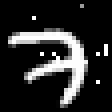

In [34]:
colorview(Gray, perturbed_sample_image[1, :, :, 1])

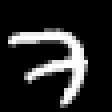

In [36]:
original_image = getvalue(d[:Input])
colorview(Gray, original_image[1, :, :, 1])

That concludes this quickstart! The next tutorial will introduce you to each of the layers, and show how you can import your own neural network parameters.